### Some Analysis of the NOAA weather dataset ###

In this notebook we are analyzing a sample out of data that was downloaded from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/, the main file is ghcnd_all.tar.gz which is about 2.4 GB which becomes around 20GB when uncompressed.

The data contains about 1 million station-year recordings. That is too much to analyzer on single core machine, so we start by taking a sample of 20,000 recordings of the maximal daily temperatures for a period of a 365 days starting on January 1st (the last day of leap years is discarded).

### Checking the versions of some important packages ###

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from pylab import *
%matplotlib inline
print 'pandas version: ',pd.__version__
print 'numpy version:',np.__version__
print 'sklearn version:',sk.__version__

pandas version:  0.14.0
numpy version: 1.8.1
sklearn version: 0.14.1


In [2]:
import os
# Get enviroment variables set from utils/setup.sh
home_dir = os.environ['HOME']
root_dir = os.environ['BD_GitRoot']

# Add utils to the python system path
sys.path.append(root_dir + '/utils')


In [3]:
#Switch to the data directory and check it's contents
%cd $root_dir/data/weather/    
#%cs ~/data/weather
!ls -lh

/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/UCSD_BigData/data/weather
total 56056
-rw-r--r--  1 yoavfreund  staff   839K Mar 27 12:23 ALL.corrupted.csv
-rw-r--r--  1 yoavfreund  staff   839K Mar 27 12:23 ALL.head.csv
-rw-r--r--  1 yoavfreund  staff   840K May  3 22:13 F1000.csv
drwxr-xr-x  8 yoavfreund  staff   272B May 15 23:10 GHCND-info
-rw-r--r--  1 yoavfreund  staff    25M Mar 27 12:23 SAMPLE_TMAX.csv
-rw-r--r--  1 yoavfreund  staff     0B May 21 14:04 ghcnd-stations_buffered.txt


- *data-source.txt* - information about downloading the data from NOAA
- *ghcnd-readme.txt* - A readme file describing the content of all of the files from ghcnd, in particular:
- *ghcnd-stations.txt* - information about each of the meteorological stations.
- *Sample_TMAX_By_Year* - a file with 10,000 randomly selected one-year-long TMAX measurements

In [4]:
!head -2 SAMPLE_TMAX.csv
# a Typical single line in the data file

USC00507570,TMAX,2005,67,44,61,17,-17,-22,-39,-44,-44,-78,-156,-156,-33,28,39,22,-89,-139,-156,44,61,50,-39,17,67,61,-61,-61,11,33,-72,-100,-150,-178,-150,-33,39,28,22,11,-150,-156,-150,50,44,28,39,50,56,39,67,50,39,56,50,56,44,22,6,17,17,61,83,67,67,89,78,61,61,83,56,44,67,89,67,89,100,83,56,17,22,50,39,28,-6,28,-6,-28,-50,-44,-33,-22,-22,-22,17,67,67,78,94,89,72,56,89,111,94,83,56,11,28,56,89,133,133,128,178,167,194,211,189,178,161,172,144,133,128,117,183,200,211,211,178,172,133,150,128,133,150,150,178,211,200,133,172,144,161,156,139,150,133,144,161,150,161,200,183,228,222,183,144,150,178,167,183,239,239,267,244,222,222,117,189,233,194,206,261,228,211,222,261,228,228,200,194,183,233,244,217,267,250,217,161,200,200,194,250,261,222,194,183,161,206,228,228,222,206,200,167,183,194,172,200,189,167,183,194,200,206,217,206,244,267,256,278,294,278,256,228,228,189,206,211,211,161,156,144,156,161,156,167,139,122,144,139,156,150,144,128,144,128,150,150,133,144,172,156,106,161,161,122,122,133,11

### read data into a Pandas Dataframe ##
* Read the data into a DataFrame
* Read the data vectors in G
* Divide by 10.0 to get the temperatude in degrees celsius
* Replace values outside the range [-400,500]  ([-40,50] degrees celsius) with nan  
* Paste fixed matrix back into Dout
* Show the first few lines of DDout

In [5]:
header=['station','measurement','year']+range(1,366)
# D=pandas.DataFrame(columns=header)
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=header)
G=Data.ix[:,1:365]
G[G<-400]=np.nan
G[G>500]=np.nan
G=G/10
Data.ix[:,1:365]=G
G=G.transpose()
Data.head()

,station,measurement,year,1,2,3,4,5,6,7,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,TMAX,2005,6.7,4.4,6.1,1.7,-1.7,-2.2,-3.9,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,TMAX,1982,NaN,NaN,-13.9,NaN,NaN,-4.5,NaN,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,TMAX,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,TMAX,1981,30.0,28.3,30.0,30.0,28.3,28.9,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


(7300000,) <class 'pandas.core.series.Series'>
-40.0 50.0


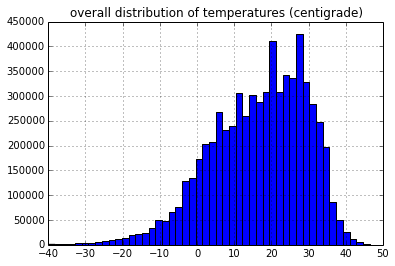

In [6]:
tmp=G.ix[:,:].unstack()
print np.shape(tmp), type(tmp)
tmp.hist(bins=50);
title('overall distribution of temperatures (centigrade)')
print tmp.min(),tmp.max()

### Script for plotting yearly plots ###

(365, 11)


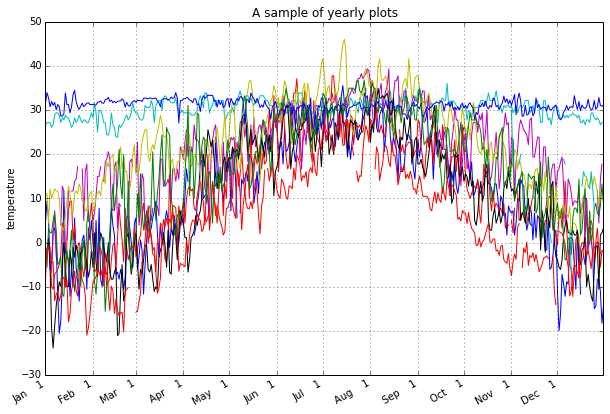

In [7]:
from datetime import date
dates=[date.fromordinal(i) for i in range(1,366)]
def YearlyPlots(T,ttl='',size=(10,7)):
    print shape(T)
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot(dates,T);
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.ix[20:30,1:365].transpose(),ttl='A sample of yearly plots')

### Plots for sydney, Australia ###

['ASN00066124' 'ASN00066059' 'ASN00066194' 'ASN00066131' 'ASN00066195'
 'ASN00066062']
(365, 6)


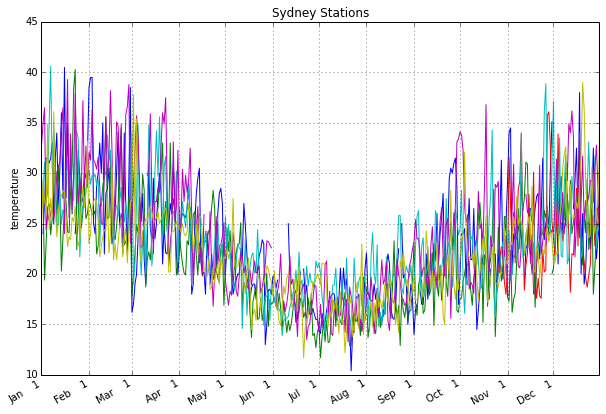

In [8]:
sydneyStations=['ASN00066' in station for station in Data['station']]
print Data[sydneyStations]['station'].values
#for station in sydneyStations:
#    print station,sum(Data['station']==station)
tmp=Data[sydneyStations].transpose()
YearlyPlots(tmp.ix[1:365,:],ttl='Sydney Stations')
#tmp.ix[:,tmp.columns[7]]
#Data[sydneyStations][['station','year']]

### Computing mean and std for each station/year ###
And calculating the standard deviation. In this case we are not divi

In [9]:
# Creat two new columns: Mean and Std, and store in them the mean and std for the row.
from numpy import mean, std
def scale_temps(Din):
    matrix=Din.iloc[:,3:]
    Dout=Din.loc[:,['station','year']+range(1,366)]
    Mean=mean(matrix, axis=1).values
    Dout['Mean']=Mean
    Std= std(matrix, axis=1).values
    Dout['Std']=Std
    # Decided not to normalize each year to have mean zero and std 1
    # tmp = pd.DataFrame((matrix.values - Mean[:,np.newaxis])/Std[:,newaxis],columns=range(1,366))
    # print tmp.head()
    Dout.loc[:,1:365]=matrix.values
    return Dout
Dout=scale_temps(Data)

#reorder the columns
Dout=Dout[['station','year','Mean','Std']+range(1,366)]
Dout.head()

,station,year,Mean,Std,1,2,3,4,5,6,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,2005,8.531507,10.439819,6.7,4.4,6.1,1.7,-1.7,-2.2,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,1959,14.494545,7.974400,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,1982,7.220513,14.897310,NaN,NaN,-13.9,NaN,NaN,-4.5,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,1964,18.576860,10.790115,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,1981,31.321370,1.588618,30.0,28.3,30.0,30.0,28.3,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


### Compute average temperature for each day of the year. ###

(365,)


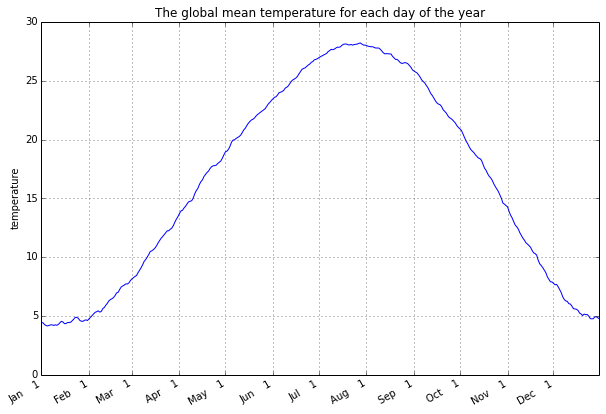

In [10]:
Mean=mean(Dout.ix[:,1:365], axis=0)
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')


### SVD ###
Using a sparse svd solver directly, using https://pypi.python.org/pypi/sparsesvd/

### Missing Values ###
We find the distribution of missing values and decide how to deal with them. From the analysis below we see that most rows have some
missing values. We therefor choose to perform the average more carefully, rather than discard rows with many missing values

3783

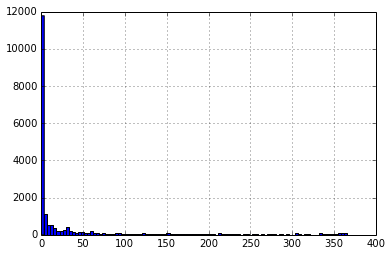

In [11]:
nan_per_row=sum(isnan(Dout.ix[:,1:365]),axis=1)
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

### NaN-tolerant averaging  ###
Compute the empirical covariance matrix in a way that tolerates NaN values.

In [12]:
M=Dout.loc[:,1:365].transpose()
M=M.dropna(axis=1)
(columns,rows)=shape(M)
Mean=mean(M, axis=1).values

print (columns,rows), shape(Mean)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries

(365, 8866) (365,)


In [13]:
%%time
# Compute the emprical covariance matrix.
for i in range(rows):
    if i % 1000==0: 
        print i
    row=M.iloc[:,i]-Mean;
    outer=np.outer(row,row)
    valid=isnan(outer)==False
    C[valid]=C[valid]+outer[valid]  # update C with the valid location in outer
    N[valid]=N[valid]+1
valid_outer=np.multiply(1-isnan(N),N>0)
cov=np.divide(C,N)

0
1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 21.3 s, sys: 176 ms, total: 21.5 s
Wall time: 21.5 s


In [14]:
#
# Compue the SVD of cov
#
%time 
print shape(cov)
U,D,V=np.linalg.svd(cov)
print shape(U),shape(D),shape(V)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 5.01 µs
(365, 365)
(365, 365) (365,) (365, 365)


### Percentage of variance Explained ###

[ 0.          0.61442763  0.72358444  0.73549968  0.7449689   0.75190399]


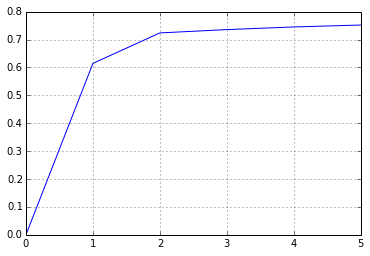

In [15]:
k=5
print ([0,]+list(cumsum(D[:k])))/sum(D)
plot(([0,]+list(cumsum(D[:k])))/sum(D))
grid()

(365, 5)


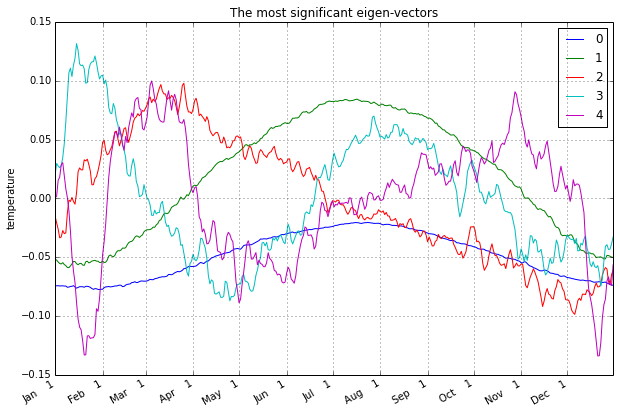

In [16]:
k=5 # number of components to show.
YearlyPlots((U[:,:k]),ttl='The most significant eigen-vectors')
legend(range(0,k));

The blue and the green curves correspond to the top two eigen-vectors. While they look similar, the 1st (blue) line mostly represents a shift in the temperatures, because it is all negative. The green represents the temperature difference between summer and winter, because it is more or less equally above and below the zero line.

In [17]:
# Compute the projection of the data on the top k eigen-vectors
k=50
Eig=np.matrix(U[:,:k])
print [np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,1:365])-Mean
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

[0.99999999999999978, 0.99999999999999967, 1.0000000000000007, 1.0000000000000002, 0.99999999999999889, 1.0, 1.0, 0.99999999999999933, 1.0000000000000009, 1.0000000000000004, 1.0000000000000004, 1.0000000000000002, 1.0, 0.99999999999999989, 1.0000000000000007, 0.99999999999999978, 1.0000000000000007, 1.0000000000000004, 1.0000000000000009, 1.0000000000000009, 1.0000000000000009, 1.0000000000000016, 1.0000000000000002, 1.0000000000000007, 1.0000000000000002, 1.0000000000000002, 1.0000000000000004, 1.0000000000000004, 0.99999999999999944, 0.99999999999999989, 0.99999999999999956, 0.99999999999999967, 0.99999999999999967, 1.0000000000000002, 0.99999999999999956, 0.99999999999999978, 1.0, 1.0000000000000004, 1.0, 1.0, 1.0000000000000002, 0.99999999999999967, 1.0, 0.99999999999999978, 1.0000000000000004, 1.0000000000000004, 0.99999999999999967, 0.99999999999999989, 0.99999999999999989, 1.0000000000000004]
(365, 50) (20000, 365)
(20000, 50)


Insert coefficients for k top eigenvectors into the dataframe **Dout**

In [18]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

,station,year,Mean,Std,V0,V1,V2,V3,V4,V5,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,2005,8.531507,10.439819,142.481893,-52.954486,33.906654,-1.390382,-26.534812,32.464267,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,1959,14.494545,7.974400,57.593976,-51.171107,21.458607,18.718011,0.623031,7.390733,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,1982,7.220513,14.897310,56.464932,27.415070,7.181212,-4.198383,2.694539,-8.357568,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,1964,18.576860,10.790115,23.514882,11.358559,23.872717,20.950578,6.612579,-3.938206,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,1981,31.321370,1.588618,-314.692267,-25.150375,-9.395788,-5.844722,-4.984370,5.335082,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


### Longitude,Latitude information ###
Loading the station longitude/latitude and merging it into the Table

In [19]:
%cd GHCND-info
!ls

/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/UCSD_BigData/data/weather/GHCND-info
data-source.txt             ghcnd-readme.txt            ghcnd-stations.txt          ghcnd-stations_buffered.txt ghcnd-version.txt           stations.pkl


In [20]:
#!cat ghcnd-readme.txt   # uncomment to read the readme file.

In [21]:
# A Hack:
# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()

In [22]:
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

In [23]:
#stations['elevation'][stations['elevation']==-999.9]=0  # decided not to remove -999.9 because this confuses hist

In [24]:
stations.head()

,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390


### perform a **JOIN** ###
Join the geographical information into **Dout**, creating a new dataframe called **Djoined**

In [25]:
Djoined=Dout.join(stations,on='station')

In [26]:
Djoined.columns[-10:]

Index([364, 365, u'latitude', u'longitude', u'elevation', u'state', u'name', u'GSNFLAG', u'HCNFLAG', u'WMOID'], dtype='object')

In [27]:
# Define a new column that contains the absolute value of the lattitude
Djoined['AbsLatitude']=abs(Djoined['latitude'].values)

In [28]:
Djoined.ix[:5,['station',u'longitude','latitude',u'AbsLatitude','Mean','Std','V0','V1','V2']]

,station,longitude,latitude,AbsLatitude,Mean,Std,V0,V1,V2
0,USC00507570,-154.3164,60.2036,60.2036,8.531507,10.439819,142.481893,-52.954486,33.906654
1,NOE00135018,10.3481,59.2300,59.2300,14.494545,7.974400,57.593976,-51.171107,21.458607
2,KZ000036546,83.6830,48.5500,48.5500,7.220513,14.897310,56.464932,27.415070,7.181212
3,USC00054664,-106.3681,40.0575,40.0575,18.576860,10.790115,23.514882,11.358559,23.872717
4,CUW00011706,-75.1500,19.9000,19.9000,31.321370,1.588618,-314.692267,-25.150375,-9.395788
5,KG000036982,78.2330,41.8830,41.8830,-12.500000,2.500000,2.583140,1.701492,2.610502


### Looking for significant correlations and dependencies ###

In [29]:
Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4','V5']].cov()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4,V5
latitude,357.338215,610.684430,-84.563827,32.995352,1677.110745,490.487718,-3.894549,47.114093,-16.377163,23.548762
elevation,610.684430,402304.438251,-553.680558,147.390961,10074.869350,295.360309,870.066289,2576.703177,894.432121,1006.311773
Mean,-84.563827,-553.680558,61.433472,-12.770270,-941.192271,52.100901,-3.614234,-5.444206,4.957587,-3.803041
Std,32.995352,147.390961,-12.770270,10.885685,294.079400,85.942955,3.992569,0.456268,-2.519408,0.569446
V0,1677.110745,10074.869350,-941.192271,294.079400,18130.395583,119.263114,7.069433,115.150954,-108.714807,75.407348
V1,490.487718,295.360309,52.100901,85.942955,119.263114,3193.165902,-13.903190,-20.520656,-13.370889,15.652342
V2,-3.894549,870.066289,-3.614234,3.992569,7.069433,-13.903190,553.284374,79.899477,-3.477208,-26.253103
V3,47.114093,2576.703177,-5.444206,0.456268,115.150954,-20.520656,79.899477,368.272027,-5.695783,-22.627756
V4,-16.377163,894.432121,4.957587,-2.519408,-108.714807,-13.370889,-3.477208,-5.695783,241.268316,-1.128021
V5,23.548762,1006.311773,-3.803041,0.569446,75.407348,15.652342,-26.253103,-22.627756,-1.128021,230.746986


In [59]:
Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4','V5']].corr()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4,V5
latitude,1.000000,0.050933,-0.570855,0.529138,0.658898,0.459174,-0.008759,0.129875,-0.055776,0.082009
elevation,0.050933,1.000000,-0.111377,0.070434,0.117966,0.008241,0.058318,0.211691,0.090786,0.104445
Mean,-0.570855,-0.111377,1.000000,-0.493821,-0.891743,0.117625,-0.019602,-0.036192,0.040718,-0.031939
Std,0.529138,0.070434,-0.493821,1.000000,0.661912,0.460934,0.051442,0.007206,-0.049157,0.011361
V0,0.658898,0.117966,-0.891743,0.661912,1.000000,0.015674,0.002232,0.044564,-0.051980,0.036867
V1,0.459174,0.008241,0.117625,0.460934,0.015674,1.000000,-0.010460,-0.018923,-0.015233,0.018235
V2,-0.008759,0.058318,-0.019602,0.051442,0.002232,-0.010460,1.000000,0.177005,-0.009517,-0.073475
V3,0.129875,0.211691,-0.036192,0.007206,0.044564,-0.018923,0.177005,1.000000,-0.019108,-0.077623
V4,-0.055776,0.090786,0.040718,-0.049157,-0.051980,-0.015233,-0.009517,-0.019108,1.000000,-0.004781
V5,0.082009,0.104445,-0.031939,0.011361,0.036867,0.018235,-0.073475,-0.077623,-0.004781,1.000000


In [60]:
# Choosing significance threshold so that none of the correlations between the Vi-s are significant.
abs(Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4','V5']].corr())>0.2

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4,V5
latitude,True,False,True,True,True,True,False,False,False,False
elevation,False,True,False,False,False,False,False,True,False,False
Mean,True,False,True,True,True,False,False,False,False,False
Std,True,False,True,True,True,True,False,False,False,False
V0,True,False,True,True,True,False,False,False,False,False
V1,True,False,False,True,False,True,False,False,False,False
V2,False,False,False,False,False,False,True,False,False,False
V3,False,True,False,False,False,False,False,True,False,False
V4,False,False,False,False,False,False,False,False,True,False
V5,False,False,False,False,False,False,False,False,False,True


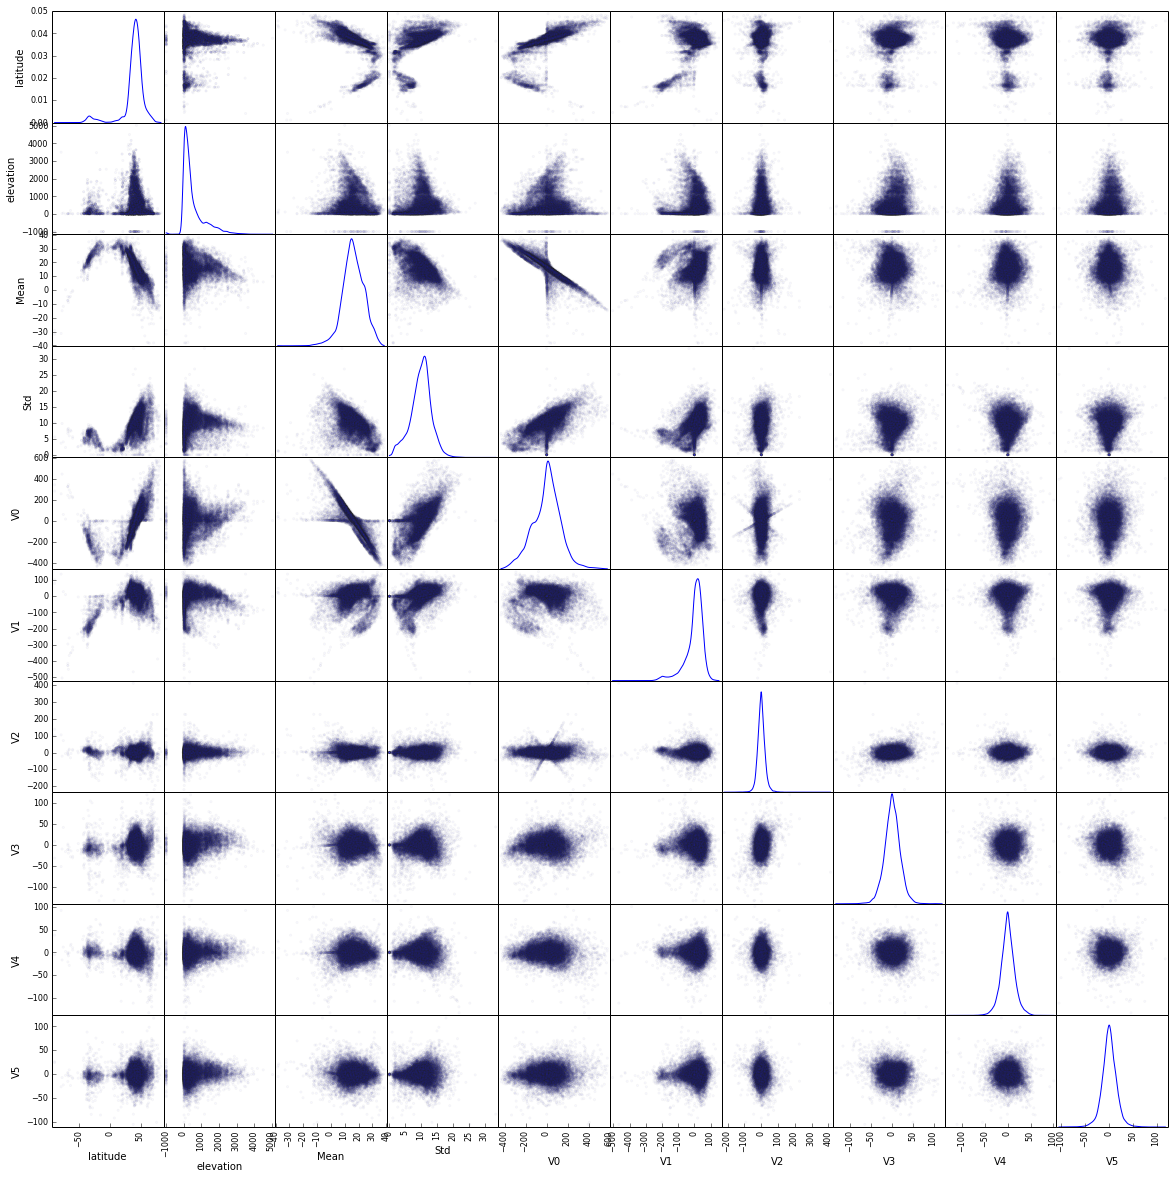

In [61]:
from pandas.tools.plotting import scatter_matrix
df = Djoined.ix[:,['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4','V5']]
scatter_matrix(df, alpha=0.03, figsize=(20, 20), diagonal='kde');

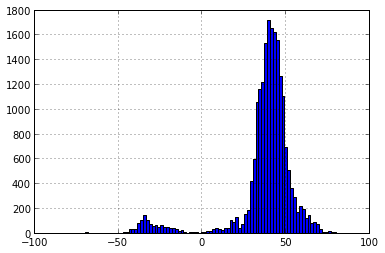

In [128]:
# Most of the data is from the northern Hemisphere.
X='latitude'
Djoined.ix[:,X].hist(bins=100);

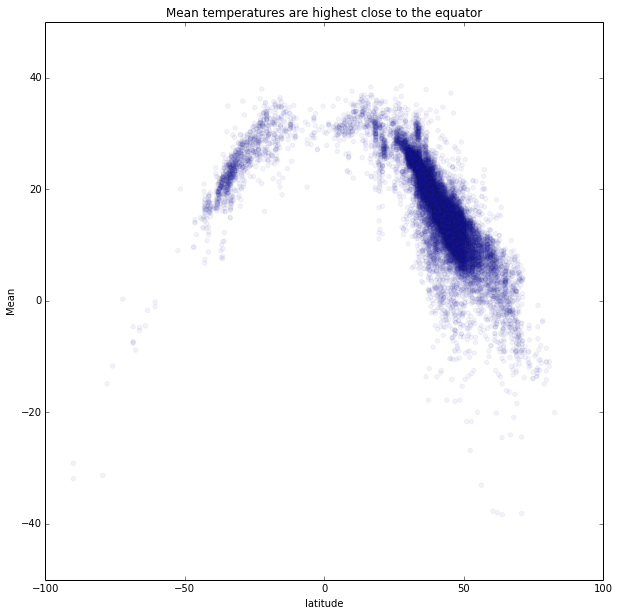

In [72]:
#Using alpha<1 makes the dots transparent so you can get a sense of density even when they overlap.
X='latitude';Y='Mean'
fig=figure(1,figsize=(10,10),dpi=300)
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)
title('Mean temperatures are highest close to the equator')

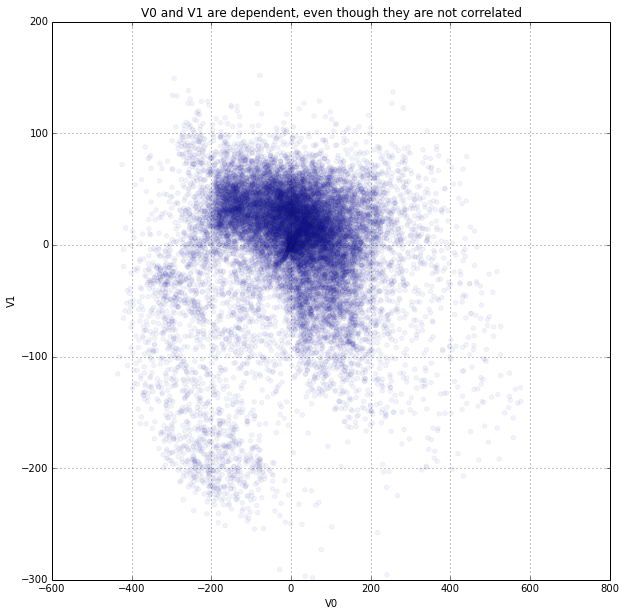

In [73]:
X='V0';Y='V1'
fig=figure(1,figsize=(10,10),dpi=300)
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)
ylim([-300,200])
grid()
title('V0 and V1 are dependent, even though they are not correlated')

In [74]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()

,station,elevation
1244,USC00301010,-999.9
1312,USC00095231,-999.9
1747,RSM00023707,-999.9
1821,BL000085041,-999.9
2192,USC00107878,-999.9


In [90]:
!grep ASN00010865 ghcnd-stations.txt

ASN00010865 -34.0333  117.2667 -999.9    LUMEAH                                      


### Reconstruction ###

(365, 50) (20000, 50) (365,)
(365, 20000) <class 'numpy.matrixlib.defmatrix.matrix'>


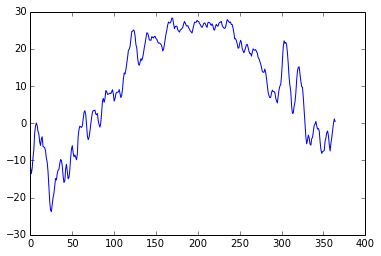

In [30]:
print shape(Eig),shape(Prod),shape(Mean)
Recon=Eig*Prod.transpose()+Mean[:,np.newaxis]
print shape(Recon),type(Recon)
plot(array(Recon[:,50]))

In [36]:
# Compute the projection of the data on the top k eigen-vectors
k=2
Eig=np.matrix(U[:,:k])
print [np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,1:365])-Mean
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

[0.99999999999999978, 0.99999999999999967]
(365, 2) (20000, 365)
(20000, 2)


In [37]:
def plot_reconstructions(selection,rows=2,columns=7):
    Recon=array(Eig*Prod.transpose()+Mean[:,np.newaxis])
    plt.figure(figsize=(columns*3,rows*3),dpi=300)
    j=0;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: break
        plot(Recon[:,i])
        plot(Djoined.ix[i,1:365]);
        title(Djoined.ix[i,'station']+' / '+str(Djoined.ix[i,'year']))
        xlim([0,365])

Observe in the reconstructions below that the blue line fills in (extrapolation/interpolation) the places where the measurements are not available. It also reduces the fluctuations relative to the original green line. Recall the we are using the k top eigenvectors which explain about 88% of the variance.

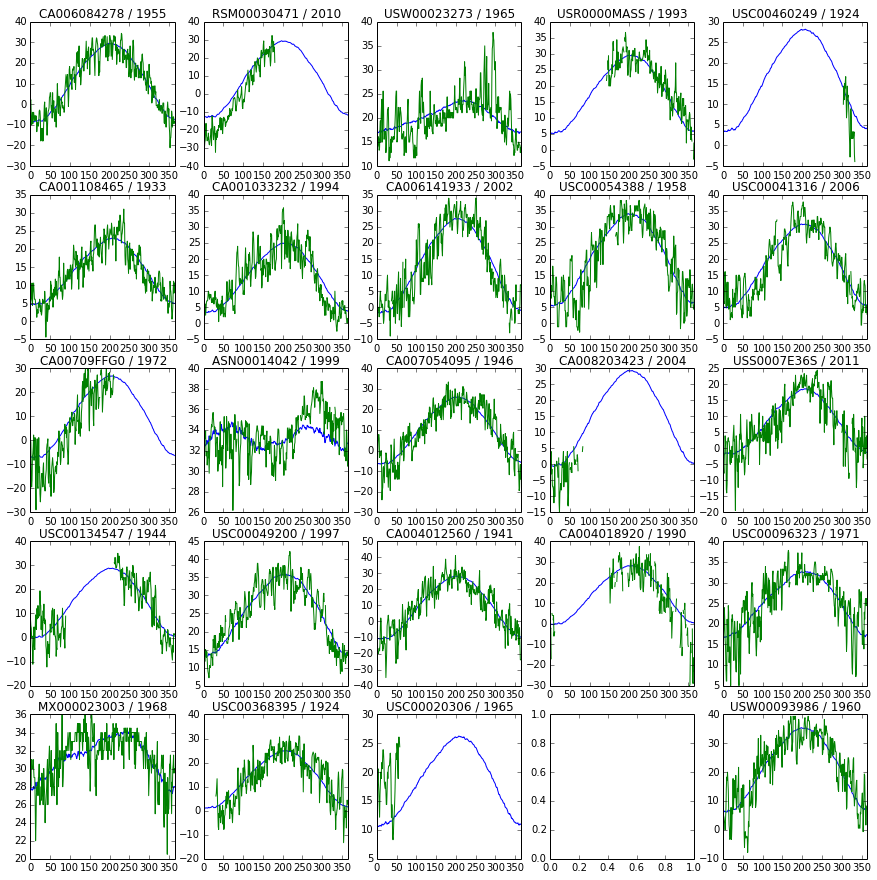

In [40]:
plot_reconstructions(range(160,185),rows=5,columns=5)

<span style="color:red"> Check how the approximations change/improve as you increase the number of coefficients</span>

(1083,)

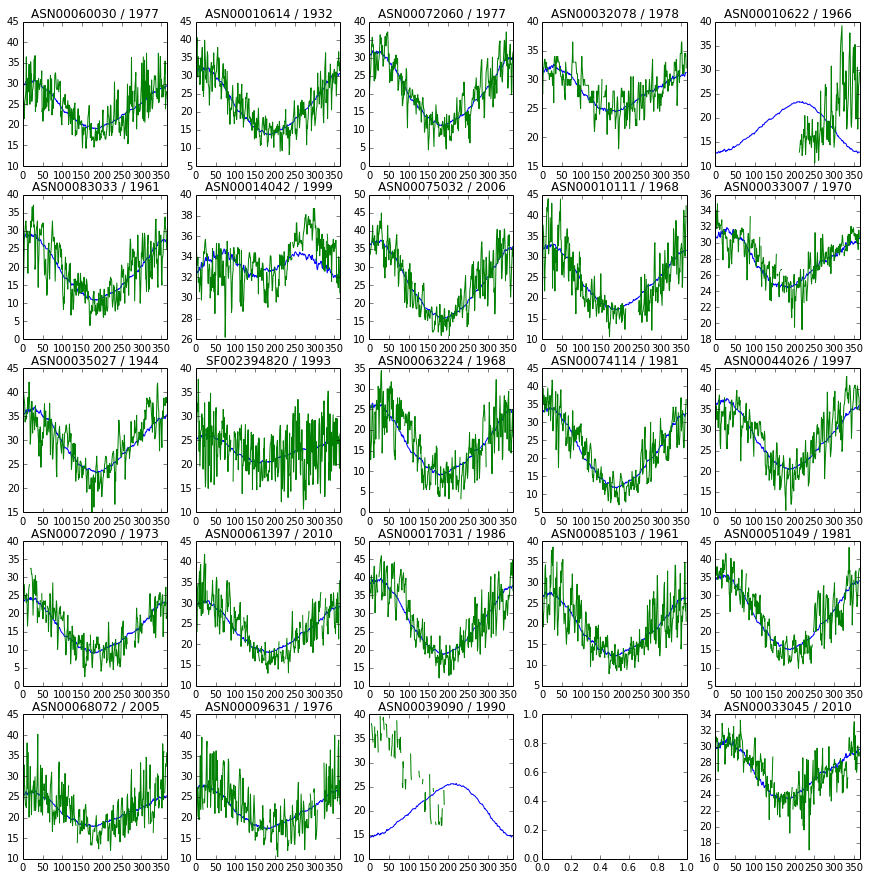

In [42]:
selection= [i for i in range(shape(Djoined)[0]) if Djoined.ix[i,'latitude']<-10]
plot_reconstructions(selection,rows=5,columns=5)
shape(selection)

** Questions **

Can you reduce the reconstruction error (using a fixed number of eigenvectors) by splitting the stations according to region (for example country, state, latitudal range). Note that having a regions with very few readings defeats the purpose.

Are the fluctuations just noise or are they local weather patterns? How can you infer this from the given data?
